I am a really big fan of the poems by [/u/poem_for_your_sprog](https://www.reddit.com/user/Poem_for_your_sprog/) on Reddit. For those of you who are not familiar with him yet; he writes short poems as responses to others on [/r/AskReddit](https://www.reddit.com/r/AskReddit/) threads. To give you an example, one that I particularly like is the following, which was written in response to a thread full of responses from ICU workers, who despite their best efforts are not always able to save every patient they meet:

```
You’ll weather the wind and the rain and the rough -
And sometimes you’ll try but it won’t be enough.

You did what you could,
but it’s not up to you.

You did what you could,
and that’s all you can do.
```
[Source](https://www.reddit.com/r/AskReddit/comments/bj4hfq/medical_workers_of_reddit_what_were_the_most/em5vsum/)


I always find it difficult to explain why I love these poems so much. Some, like the above, stand out in simplicity; six short lines that bring a message that speaks to many of us. But there's more elaborate ones, and really funny ones too. I would love to understand a little bit better what exactly it is that makes these poems so appealing to me, and to get a better grasp of the artform behind it. Sadly, I know absolutely nothing about poetry. And since I'm also not as good with words as [/u/poem_for_your_sprog](https://www.reddit.com/user/Poem_for_your_sprog/), I will try to understand poetry in the only way I know how: By using data.

My plan is to create a dataset of all the poems [/u/poem_for_your_sprog](https://www.reddit.com/user/Poem_for_your_sprog/) has written, and create a number of notebooks that dive into these works. In this first notebook, I want to explore some basic statistics about these poems.

You can find the notebook with python code that was used to create this page on [GitHub](https://github.com/flo12392/poems/blob/master/1.0-summary-statistics-upvotes-and-awards.ipynb).

In [237]:
%%capture
%load_ext autoreload
%autoreload 2

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')

In [238]:
import string
import datetime as dt
import pandas as pd
import numpy as np
import time
import re
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from src.utils import print2_list, print2
from src.plotly import plot_histogram, plot_timeline, plot_horizontal_bar, plot_heatmap, plot_scatter, plot_events_timeline
from src.reddit_user_comment_reader import RedditUserCommentReader
from src.data_frame_parser import DataFrameParser

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

comment_reader = RedditUserCommentReader('poem_for_your_sprog','data')
df = comment_reader.read()
df = DataFrameParser().parse(df)

# Comments per day

Let's start by simply looking at the amount of poems over time. We can see below that on the extraordinarily productive days, sprog provides us with about 5 or 6 poems, and his productivity seems to have increased somewhat over time. The outlier of 12 comments in June is the ['Ask Me Anything'](https://www.reddit.com/r/books/comments/3aungz/hi_im_sam_garland_aka_upoem_for_your_sprog_ive/), or AMA in short, where he answered questions of fellow Redditors.

In [239]:
df_comments_per_day= df.groupby(['date'])['date'].agg(n='count')
idx = pd.date_range(df_comments_per_day.index.min(), dt.datetime.today())
df_comments_per_day = df_comments_per_day.reindex(idx, fill_value=0)

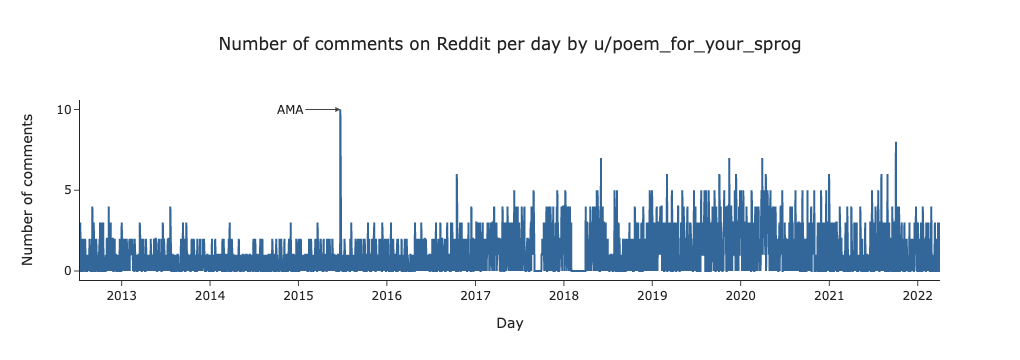

In [240]:
fig = plot_timeline(
    x=df_comments_per_day.index,
    y=df_comments_per_day['n'],
    title='Number of comments on Reddit per day by u/poem_for_your_sprog',
    xaxis_title='Day',
    yaxis_title='Number of comments',
    annotations=[
        go.layout.Annotation(
            x='2015-6-23',
            y=10,
            xref="x",
            yref="y",
            text="AMA",
            showarrow=True,
            arrowhead=2,
            ax=-50,
            ay=0
        )
    ]
)
fig.show()
fig.write_json('plots/plot_1_comment_count_per_day.json')

This plot was usful to determine the AMA outlier, so lets remove the observations from that day from our dataset. However, the daily plot does not really help us in identifying a trend, so let's aggregate the data to monthly buckets to get a clearer view:

In [241]:
# Remove AMA comments
df = df[df['date']!=dt.date(2015,6,23)]
df.reset_index(inplace=True)

In [242]:
comments_per_month = df_comments_per_day.groupby(pd.Grouper(freq='M'))['n'].sum()

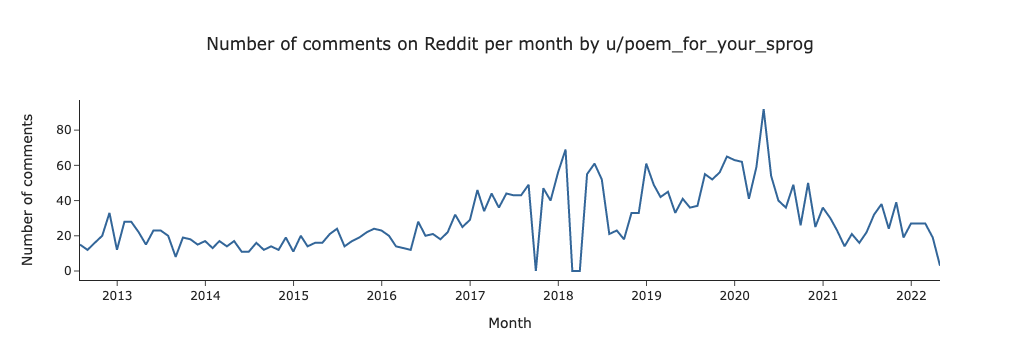

In [243]:
fig = plot_timeline(
    x=comments_per_month.index,
    y=comments_per_month,
    title='Number of comments on Reddit per month by u/poem_for_your_sprog',
    xaxis_title='Month',
    yaxis_title='Number of comments'
)
fig.show()
fig.write_json('plots/plot_2_comment_count_per_month.json')

Not all poems by sprog have been posted on /r/AskReddit threads, he also responded to posts on some other subreddits:

In [244]:
print('In total, there are {} comments by /u/poem_for_your_sprog on Reddit. \nOut of those, {:.1f}% were comments within /r/AskReddit.'
      .format(len(df), 
              len(df[df['subreddit_name_prefixed']=='r/AskReddit'])/len(df)*100)
     )

In total, there are 3418 comments by /u/poem_for_your_sprog on Reddit. 
Out of those, 96.1% were comments within /r/AskReddit.


It would be interesting to find out to which other subreddits sprog has posted his poems in the past. To gain insight in the temporary pattern of these poems and in the distribution of these poems over the subreddits simultaneously, we can create a plot with multiple timelines and denote the comments as events in a scatter plot. You can hover over the plot to read the poems.

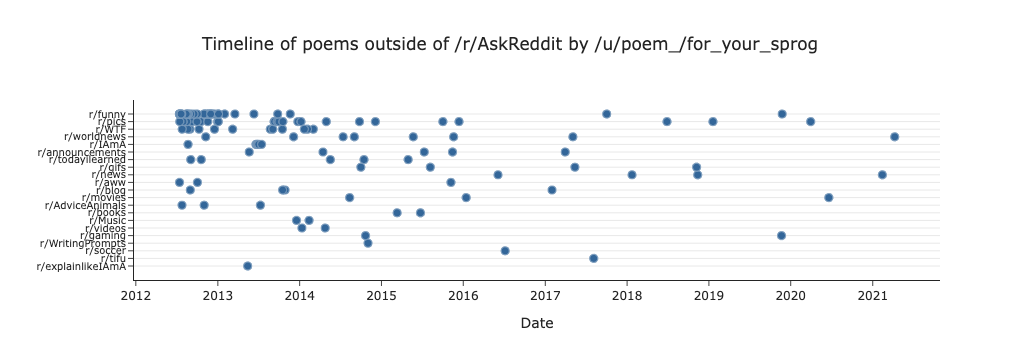

In [245]:
df_poem_per_sub = df[df['subreddit_name_prefixed']!='r/AskReddit'][['subreddit_name_prefixed','date','poem','ups']]
df_poem_per_sub['poem_ups'] = ['Upvotes: {}>'.format(row['ups']) + row['poem'] for ix, row in df_poem_per_sub.iterrows()]
df_poem_per_sub = (
    df_poem_per_sub
    .groupby(['subreddit_name_prefixed','date'])['poem_ups']
    .agg(poem_ups =  lambda x: '>---->'.join(list(x)), count = len)
    .reset_index(inplace=False)
)
df_poem_per_sub['subreddit_total'] = (
    df_poem_per_sub['count']
    .groupby(df_poem_per_sub['subreddit_name_prefixed'])
    .transform('sum')
)
df_poem_per_sub = df_poem_per_sub.sort_values('subreddit_total')

fig = plot_events_timeline(
    x = df_poem_per_sub['date'],
    y = df_poem_per_sub['subreddit_name_prefixed'],
    text=["Total poems: {}<br>----<br>".format(row['count']) + re.sub('>','<br>',row['poem_ups']) for ix,row in df_poem_per_sub.iterrows()],
    title = 'Timeline of poems outside of /r/AskReddit by /u/poem_/for_your_sprog',
    xaxis_title = 'Date',
    yaxis_title = ''
)
fig.show()
fig.write_json('plots/plot_3_comments_outside_of_askreddit.json')

The total number of subreddits that sprog has written poems on is fairly limited. It's also clear to see that in the early days there were many more comments outside of [/r/AskReddit](https://www.reddit.com/r/AskReddit/) threads than there have been in the past few years. 

It also seems like we have some more outliers to filter. For example, by hovering over the marker in December in the timeline of [/r/worldnews](https://www.reddit.com/r/worldnews/) we find a very long line that is clearly not part of a poem; that's a regular comment. So let's continue by analyzing the basic structure of the comments to see if we can identify a method to filter out these outliers.

# Average line length

Sprog writes both poems with very short lines, as well as poems with longer ones. A histogram of the average number of characters on a line per poem should give us a better idea of the distribution:

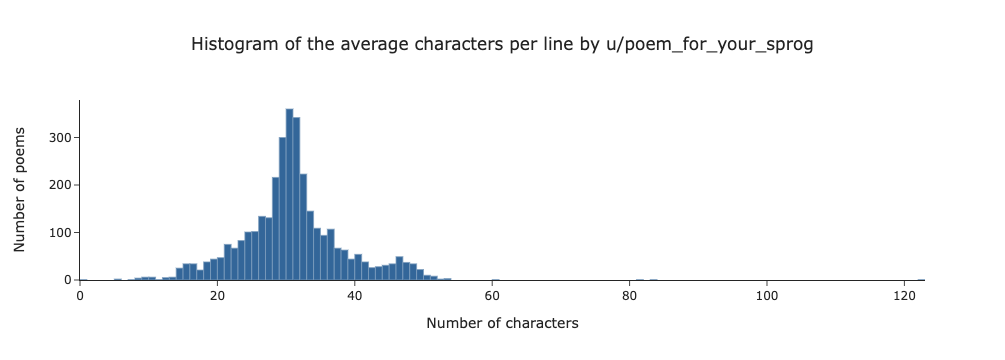

In [246]:
fig = plot_histogram(
    x = df['average_line_length'],    
    params = {'xbins':dict(start=0,end=200,size=1)},
    title = 'Histogram of the average characters per line by u/poem_for_your_sprog',
    xaxis_title = 'Number of characters',
    yaxis_title = 'Number of poems'
)

fig.show()
fig.write_json('plots/plot_4_characters_per_line.json')

There are three clear outliers, which upon further inspection are not poems, or contain a lot of text alongside the poem. We will filter those out for now. Furthermore, the peak around 46 is interesting to see. My initial guess was that some rhymes are written in the rhyme scheme `abab`, while others are split out over shorter lines in the rhyme shape `abcb defe`, so the former would on average have lines twice as long as the latter. But that does not seem to hold; then the first peak should be around 23 instead of 30.

When I took a look at the rows corresponding to that peak, I found out that they all had a similar 'flow' to them. A bit of Googling made me relaize that this is called poetic [metre](https://en.wikipedia.org/wiki/Metre_(poetry)). There, I learned something about poetry already. It turns out that these are a set of poems that sprog usually writes in 'Anapestic tetrameter'. Anapestic tetrameter is a metre with four anapestical feet per line. An anapestical foot is two unstressed syllables, followed by a stressed one. So, denoting a stressed syllable as / and an unstressed syllable as x, an anapestic tetrameter can de denoted as follows:

> x x / x x / x x / x x /

However, sprog usually omits the first unstressed syllable, so it becomes:

>   x / x x / x x / x x /

To get a better idea, here is an example of one of these poems:

```
you don't need a measure of treasure to fly
to sporting success on a broom in the sky...
to eros alone in the sight of the stars...
to space on a ship that's intended for mars.
you don't need a mountain of money to go
where peter and susan await in the snow...
where planets contend and defend for a spice...
where alice adventures with hatters and mice.
you don't need a wallet of wealth and of worth
to start on a journey across middle earth...
to fight in the night with your sword and your steed.
you don't need a fund or a fortune to read.
```
[Source](https://www.reddit.com/r/AskReddit/comments/5tek1p/what_is_a_great_poor_person_hobby/ddm5vcl/	)


I feel there's a lot more to learn about metre. But that seems to be a very broad topic, so let's save that for another notebook, and let's try to get a better feeling of the basic structure of the poems first. For example, it would be interesting to take a look at some of the poems with very short or very long line lengths to see what they look like. However, listing all the poems here would make this notebook quite long, so let's just plot them. In the figure below, I have put the 100 poems with the shortest average line length and the the 100 poems with the longest average line length in a plot that allows you to read the poems by hovering over the points. 

In [247]:
df = df[df['average_line_length']<55]
df = df[df['poem'].apply(len)>0]
df = df[df['number_of_lines']>1]

In [248]:
df_short = df.sort_values('average_line_length').head(100)
df_long = df.sort_values('average_line_length',ascending=False).head(100)
df_short_long = pd.concat([df_short,df_long])

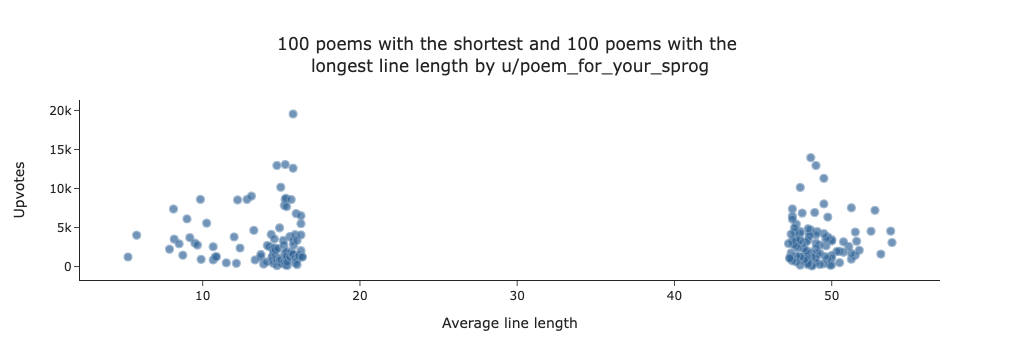

In [249]:
fig = plot_scatter(
    x=df_short_long['average_line_length'],
    y=df_short_long['ups'],
    text=[re.sub('>','<br>',row['poem']) for ix, row in df_short_long.iterrows()],
    title='100 poems with the shortest and 100 poems with the <br>longest line length by u/poem_for_your_sprog',
    xaxis_title='Average line length',
    yaxis_title='Upvotes'
    )
fig.show()
fig.write_json('plots/plot_5_short_and_long_poems.json')

If you're done reading, let's move on to another histogram; the number of lines per poem.

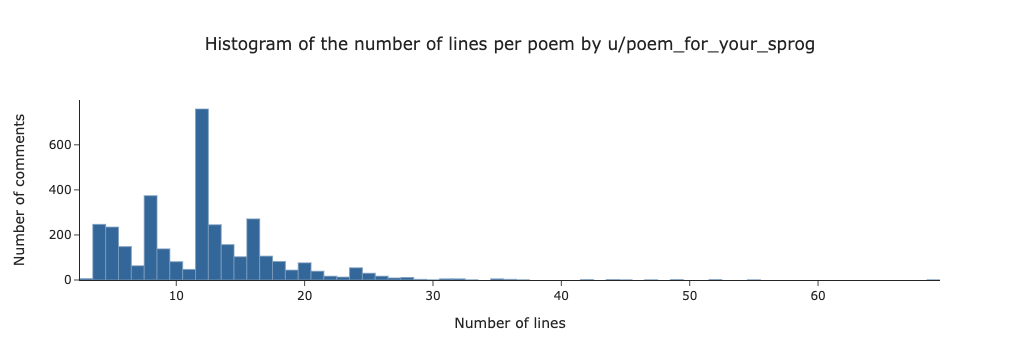

In [250]:
fig = plot_histogram(
    x = df['number_of_lines'],    
    params = {'xbins':dict(size=1)},
    title = 'Histogram of the number of lines per poem by u/poem_for_your_sprog',
    xaxis_title = 'Number of lines',
    yaxis_title = 'Number of comments'
)

fig.show()
fig.write_json('plots/plot_6_hist_number_of_lines.json')

This looks like something one might expect as well; poems usually have an even amount of lines, since we usually rhyme one line with another. The most common rhyme schemes I can think of are `abab`, and `abcb`, so it also makes sense that the highest peaks are at 4, 8, 12, and 16, which are multiples of four.

The values directly following those numbers (5, 9, 13 and 17) also are relatively high. This seems to be caused by a characteristic way of breaking the last line into two lines to build some tension or to give some extra stress to the final line. An example:


```
you're disturbed and defiled and depraved and debased?
you're obscene and corrupt and debauched and disgraced?
you're perverse and profane and you freely confess?
and with pride, he replied with a confident
... yes.
```
[Source](https://www.reddit.com/r/AskReddit/comments/c4xbbn/people_who_have_found_their_friends_secret_reddit/erzjnhf/)

And sometimes multiple lines in a poem are split up, or one line is split up into more than two parts, explaining the fact that the peak after each multiple of four decays until the next multiple of four. An example of this:

```
and when the darkness comes for me
to take me where i'm meant to be -
to guide me out beyond the black,
forever on,
and never back -
to lead me through the final door
till all that is and was before
is nothing more than dreams at night -
i will not fret.
i will not fight.
```
[Source](/r/AskReddit/comments/99q9n5/redditors_who_have_been_clinically_dead_what_did/e4q0a2w/)

# Upvotes & Awards

On Reddit, there are two ways to show appreciation for a comment. One can upvote a post, of spend some actual money to give the post an award. Let's start by simply counting the upvotes:

In [251]:
print('Total number of upvotes on poems by /u/poem_for_your_sprog: {:,}'.format(df['ups'].sum()))

Total number of upvotes on poems by /u/poem_for_your_sprog: 9,108,333


Is that a lot? In order to find out, let's try to express it in Big Mac's. Here is a little thing I found on the internet (so it must be true):

> According to research conducted by Vanderbilt University Medical Center, laughing for 10 to 15 minutes burns between 10 and 40 calories a day.

Let's first assume that smiling is on the bottom of this spectrum, i.e. 15 minutes of smiling consumes 10 calories. Now let's assume that an upvote equals a second of smiling on average. Then we now have enough information to convert our number of upvotes to Big Mac's!

In [252]:
cal_per_sec = 10/(15*60)
cal_per_smile = cal_per_sec * 1
total_cals_smiled = df['ups'].sum() * cal_per_smile
cal_per_big_mac = 564
n_big_mac = round(total_cals_smiled/cal_per_big_mac,1)
print('Calories per second of smiling: {0:.4f}'.format(cal_per_sec))
print('Calories per smile: {0:.4f}'.format(cal_per_smile))
print('Number of smiles: {:,}'.format(df['ups'].sum()))
print('Total calories smiled: {0:,.1f}'.format(total_cals_smiled))
print('Calories per Big Mac: {0:.1f}'.format(cal_per_big_mac))

print('In total, {} Big Mac\'s worth of calories have been consumed by smiles that were caused by poems by /u/poem_for_your_sprog.'
     .format(n_big_mac))

Calories per second of smiling: 0.0111
Calories per smile: 0.0111
Number of smiles: 9,108,333
Total calories smiled: 101,203.7
Calories per Big Mac: 564.0
In total, 179.4 Big Mac's worth of calories have been consumed by smiles that were caused by poems by /u/poem_for_your_sprog.


Disclaimer; I am not a dietician nor a physicist. Experimental results are needed to verify the above, but I have not found any volunteers yet. Please let me know if you're interested in participating.

Next, let's take a look at the awards that sprog has earned. There are (at least) three types of awards;
- Silver, granting the user.. nothing.
- Gold, granting the user Reddit Premium for a week
- Platinum, granting the user Reddit Premium for a month

Below is a pie chart that shows the breakdown of the awards /u/poem_for_your_sprog has been given. Yes, I know many people don't like pie charts. Although I dough not really care, I have added a hole in the middle to make it a donut chart. As long as it's food related I'm happy.

In [253]:
from collections import Counter
c = Counter()
for d in df['awards_dict']:
    c.update(d)

df_awards = (
    pd.DataFrame.from_dict(
        dict(c), 
        orient='index', 
        columns =['count']
    )
    .reset_index()
    .sort_values('count', ascending=False)
)

df_awards['index'][~df_awards['index'].isin(df_awards['index'].head(10))] = 'other'
df_awards = df_awards.groupby('index')['count'].sum().reset_index().sort_values('count', ascending=True)

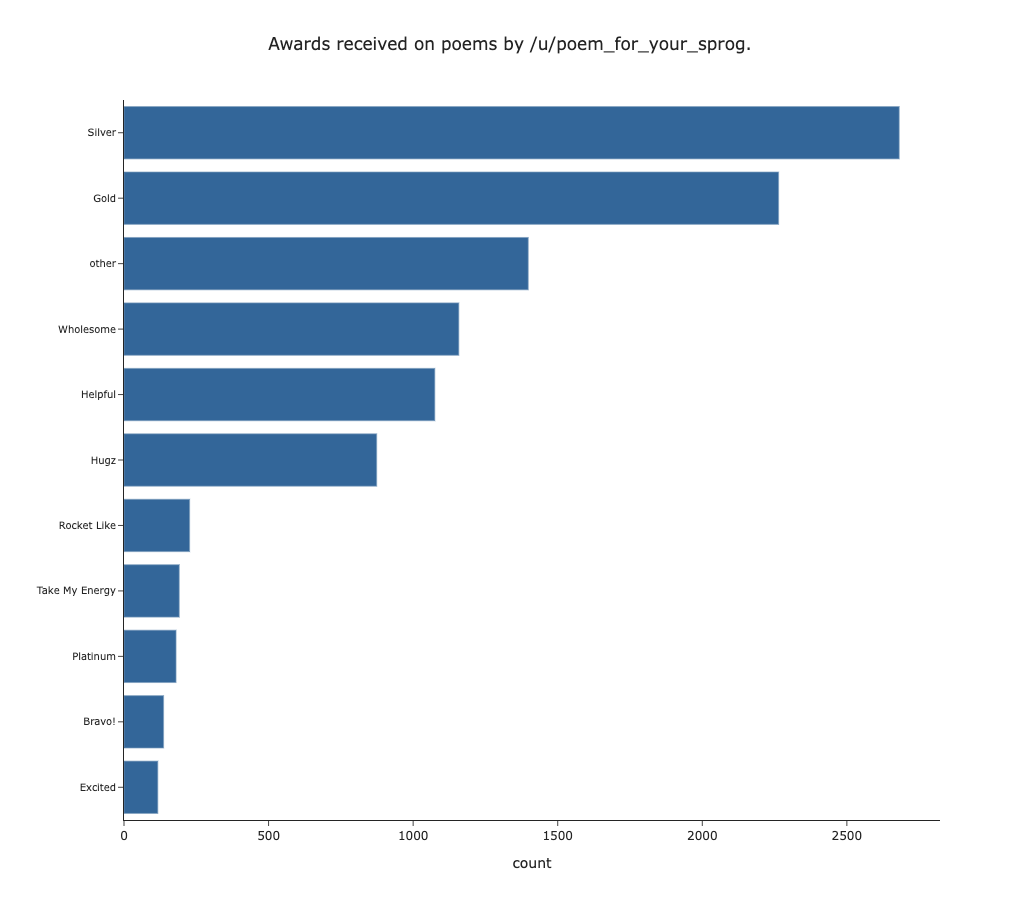

In [254]:
fig = plot_horizontal_bar(labels=[x[0] for i, x in df_awards.iterrows()], 
                    values=[x[1] for i, x in df_awards.iterrows()],
                    title = 'Awards received on poems by /u/poem_for_your_sprog.',
                    xaxis_title = 'count', 
                    yaxis_title = "")

fig.show()
fig.write_json('plots/plot_7_awards.json')

That's a lot of gold! Almost matches China's aspirations for the Olympic Games in 2028.

Below are three more graphs. The first is a histogram of the number of upvotes per post, and the second is a histogram of the number of awards per post. The last graph shows the 100 most upvoted poems and the 100 poems with the most awards written by /u/poem_for_your_sprog on Reddit with the number of upvotes on the y-axis and the number of awards on the x-axis. You can hover over the points to read the poems!

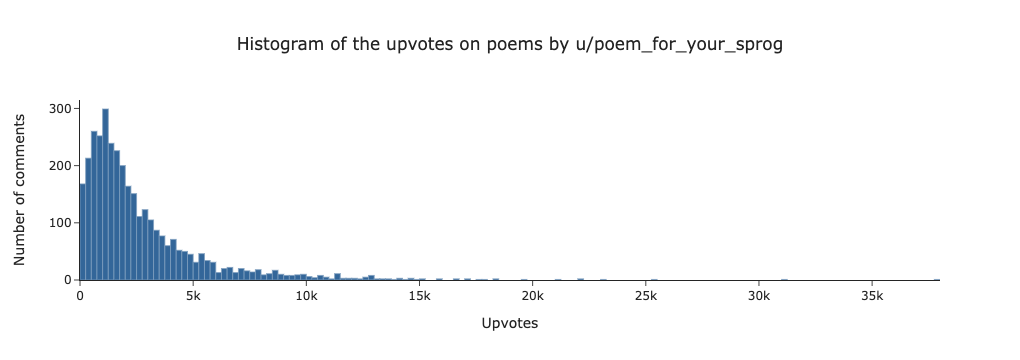

In [255]:
fig = plot_histogram(
    x = df['ups'],    
    params = {'xbins':dict(size=250)},
    title = 'Histogram of the upvotes on poems by u/poem_for_your_sprog',
    xaxis_title = 'Upvotes',
    yaxis_title = 'Number of comments'
)
fig.show()
fig.write_json('plots/plot_8_hist_upvotes.json')

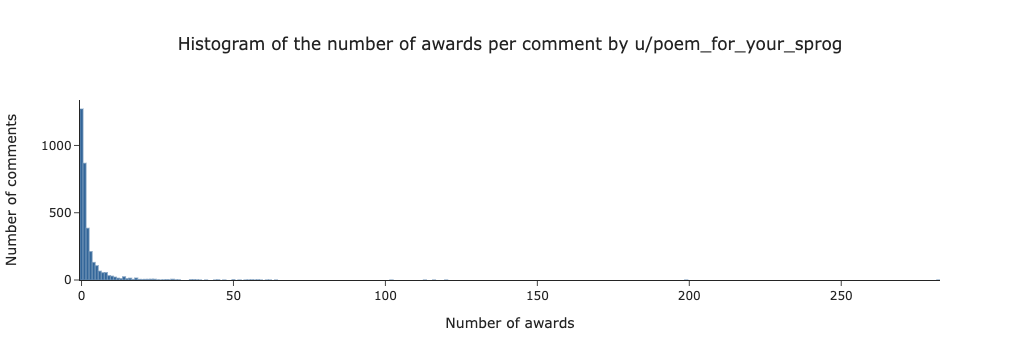

In [256]:
fig = plot_histogram(
    x = df['total_awards_received'],    
    params = {'xbins':dict(size=1)},
    title = 'Histogram of the number of awards per comment by u/poem_for_your_sprog',
    xaxis_title = 'Number of awards',
    yaxis_title = 'Number of comments'
)
fig.show()
fig.write_json('plots/plot_9_hist_awards.json')

In [257]:
top_awards = df['total_awards_received'].sort_values(ascending=False).index[:100]
top_upvotes = df['ups'].sort_values(ascending=False).index[:100]
top_poems = top_awards.union(top_upvotes)
df_top = df.loc[top_poems]

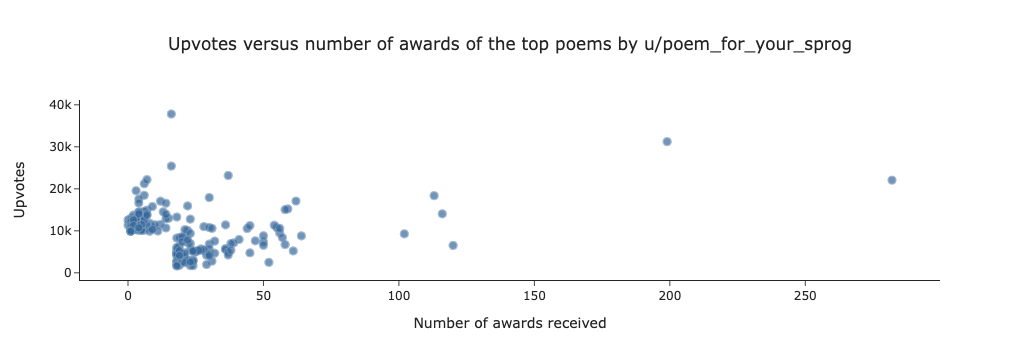

In [258]:
fig = plot_scatter(
    x=df_top['total_awards_received'],
    y=df_top['ups'],
    text=['upvotes: {}<br>awards: {}<br><br>'.format(row['ups'],row['total_awards_received']) 
                  + re.sub('>','<br>',row['poem']) for index, row in (df_top).iterrows()],
    title='Upvotes versus number of awards of the top poems by u/poem_for_your_sprog',
    xaxis_title='Number of awards received',
    yaxis_title='Upvotes'
    )
fig.show()
fig.write_json('plots/plot_10_most_upvotes_and_awards.json')

Hovering over the right side of the plot, we find quite some poems that have many lines, which might lead us to believe that longer poems are awarded with silver, gold or platinum more often. The correlation plot below confirms that; the number of awards and the number of lines have a positive correlation.
Also, in the plot we find two things that we might have expected to find; score and total awards received are positively correlated, and poems with many lines have in general a lower average line length, although the correlation coefficient of the latter is not very large.

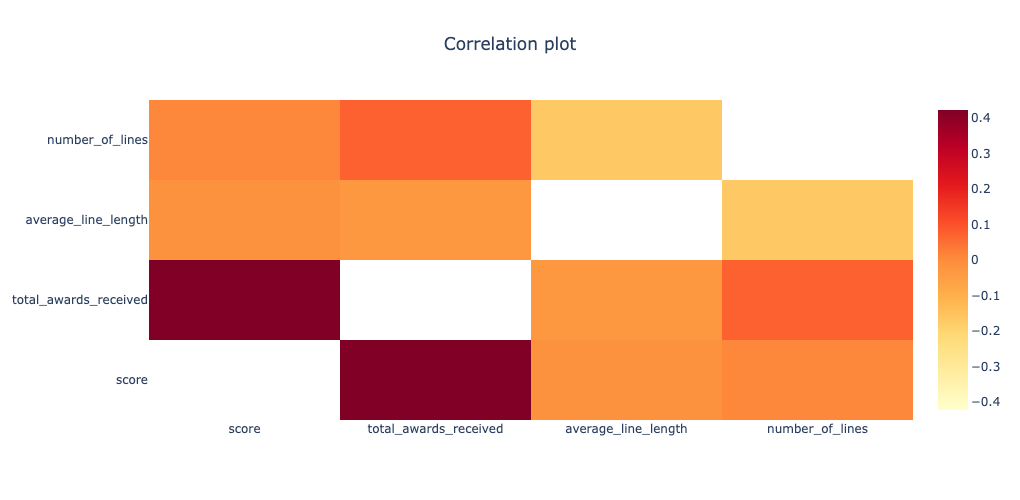

In [259]:
df_corr = df[['score','total_awards_received','average_line_length','number_of_lines']].corr()
df_corr[df_corr==1]=np.nan

fig = plot_heatmap(
    z = df_corr.values,
    x = df_corr.columns,
    y = df_corr.columns,
    title = 'Correlation plot',
    figsize = (600,500)
)
fig.show()
fig.write_json('plots/plot_11_correlation.json')

That's enough exploring poems for now! This helped in providing a better sense of the data by doing some initial exploration, but I think there's still a lot to find that can help me understand the art behind the poems better. In a next notebook I will try to dive a bit deeper into the things that make a poem a poem, such as meter or rhyme.

In [260]:
front_matter_str = """---
layout: post
title: "Poetry & Data I: Exploration"
subtitle: Analyzing the comment history of /u/poem_for_your_sprog on Reddit
tags: [python, poetry, poem_for_your_sprog, reddit]
layout: html_post
---"""